In [2]:
# COMP 5300 Final Project
# Musculoskeletal Abnormality Detection
# Michelle, Jennifer, Amelia, Deva

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
%matplotlib inline
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [4]:
def restructure_dataset(path):
    data = []
    
    for study_type in os.listdir(path):
        # Get study type path to access patient folders
        study_type_path = path + '/' + str(study_type)

        for patient_id in os.listdir(study_type_path):
            # Get patient id path to access study folders
            study_id = study_type_path + '/' + str(patient_id)
            for label in os.listdir(study_id):
                # Get abnormality label as positive (1) or negative (0)
                if label.split('_')[-1] == 'positive': 
                    num_label = 1
                elif label.split('_')[-1] == 'negative':
                    num_label = 0

                # Get study id and label path to access image folders
                label_path = study_id + '/' + str(label)
                for img in os.listdir(label_path):
                    img_path = label_path + '/' + str(img)

                    # Add data to array
                    data.append(
                        {
                            'study_type': study_type,
                            'patient_id': patient_id,
                            'img_path': img_path,
                            'label': num_label,
                        }
                    )
    return data

In [5]:
# Consolidate all training data into single dataframe 
df_train = pd.DataFrame(restructure_dataset('MURA-v1.1/train'))
df_train.head()

,study_type,patient_id,img_path,label
0,XR_FOREARM,patient09232,MURA-v1.1/train/XR_FOREARM/patient09232/study1...,1
1,XR_FOREARM,patient09232,MURA-v1.1/train/XR_FOREARM/patient09232/study1...,1
2,XR_FOREARM,patient09202,MURA-v1.1/train/XR_FOREARM/patient09202/study1...,1
3,XR_FOREARM,patient09202,MURA-v1.1/train/XR_FOREARM/patient09202/study1...,1
4,XR_FOREARM,patient09396,MURA-v1.1/train/XR_FOREARM/patient09396/study1...,0


In [6]:
df_train.shape

(36812, 4)

In [7]:
df_train.isnull().sum()

study_type    0
patient_id    0
img_path      0
label         0
dtype: int64

In [8]:
# Preprocessing & stratified sampling to get validation dataset

df_train['combined_study_type_label'] = df_train['study_type'] + '_' + df_train['label'].astype(str)

df_train, df_valid = train_test_split(df_train, test_size = 0.1, stratify = df_train['combined_study_type_label'])

df_train = df_train.drop(columns=['combined_study_type_label'])
df_valid = df_valid.drop(columns=['combined_study_type_label'])

In [9]:
df_train.head()

,study_type,patient_id,img_path,label
22089,XR_WRIST,patient07163,MURA-v1.1/train/XR_WRIST/patient07163/study1_p...,1
32470,XR_ELBOW,patient05168,MURA-v1.1/train/XR_ELBOW/patient05168/study1_p...,1
4760,XR_HAND,patient10017,MURA-v1.1/train/XR_HAND/patient10017/study2_ne...,0
24852,XR_WRIST,patient01817,MURA-v1.1/train/XR_WRIST/patient01817/study1_n...,0
6915,XR_HAND,patient10979,MURA-v1.1/train/XR_HAND/patient10979/study1_ne...,0


In [10]:
df_train.shape

(33130, 4)

In [11]:
df_valid.head()

,study_type,patient_id,img_path,label
34520,XR_ELBOW,patient06175,MURA-v1.1/train/XR_ELBOW/patient06175/study1_n...,0
26832,XR_WRIST,patient07985,MURA-v1.1/train/XR_WRIST/patient07985/study1_n...,0
12722,XR_SHOULDER,patient02167,MURA-v1.1/train/XR_SHOULDER/patient02167/study...,0
22197,XR_WRIST,patient08761,MURA-v1.1/train/XR_WRIST/patient08761/study1_n...,0
10395,XR_FINGER,patient03520,MURA-v1.1/train/XR_FINGER/patient03520/study1_...,1


In [12]:
df_valid.shape

(3682, 4)

In [13]:
# Consolidate all test data into single dataframe
df_test = pd.DataFrame(restructure_dataset('MURA-v1.1/valid'))
df_test.head()

,study_type,patient_id,img_path,label
0,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0
1,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0
2,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0
3,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0
4,XR_FOREARM,patient11408,MURA-v1.1/valid/XR_FOREARM/patient11408/study1...,1


In [14]:
df_test.shape

(3197, 4)

In [15]:
df_test.isnull().sum()

study_type    0
patient_id    0
img_path      0
label         0
dtype: int64

In [16]:
# Find problematic images and remove them from the dataset (amelia)
# https://stackoverflow.com/questions/71572762/cannot-identify-image-file-io-bytesio-object-at-0x000001e6cf13a108
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

all_image_paths = []
all_image_paths.extend(df_train['img_path'])
all_image_paths.extend(df_valid['img_path'])
all_image_paths.extend(df_test['img_path'])

problem_paths = []

for img_p in all_image_paths:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
        print(img_p)
        problem_paths.append(img_p)

for prob_path in problem_paths:
    df_train.drop(df_train.loc[df_train['img_path']==prob_path].index, inplace=True)
    df_valid.drop(df_valid.loc[df_valid['img_path']==prob_path].index, inplace=True)
    df_test.drop(df_test.loc[df_test['img_path']==prob_path].index, inplace=True)

MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image2.png
MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image1.png
MURA-v1.1/train/XR_WRIST/patient07840/study1_negative/._image1.png
MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image3.png


In [17]:
# Convert labels to str
df_train['label'] = df_train['label'].replace({0: '0', 1: '1'})
df_valid['label'] = df_valid['label'].replace({0: '0', 1: '1'})
df_test['label'] = df_test['label'].replace({0: '0', 1: '1'})

In [18]:
# Data augmentation
datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = None,
    x_col = 'img_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224, 224),
)

Found 33127 validated image filenames belonging to 2 classes.


In [19]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = None,
    x_col = 'img_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224, 224),
)

Found 3681 validated image filenames belonging to 2 classes.


In [20]:
test_generator = datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = None,
    x_col = 'img_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = False,
    class_mode = 'binary',
    target_size = (224, 224),
)

Found 3197 validated image filenames belonging to 2 classes.


In [22]:
# https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
# https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
# https://medium.com/geekculture/boost-your-image-classification-model-with-pretrained-vgg-16-ec185f763104
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


print("Current CUDA device:", tf.test.gpu_device_name())


# # load the labaled data
# #no headers on csv will references by index 
# train_labeled_data = pd.read_csv('MURA-v1.1/train_labeled_studies.csv', header=None)
# train_images_paths = pd.read_csv('MURA-v1.1/train_image_paths.csv', header=None)

# #resize all images and process images as a numpy array
# def process_train_images(img_path):
#     img = load_img(img_path, target_size = (128,128)) #resize to 244 to keep consistant with Michelle's code
#     img_arr = img_to_array(img)
#     return img_arr


# train_images = []
# train_labels = []

# # iterate through dir to correspond img to the correct label
# #TODO: discuss this portion with Michelle 
#     #@Michelle I wasnt able to load my model on the same notebook as yours ... I  kept running out of resources for some reason??
#     # I dont think this includes the data aug you did .. 
#     #please feel free to edit this part to optmize 
# for dir_path, label in zip(train_labeled_data[0], train_labeled_data[1]):
#     image_to_label = train_images_paths[0][train_images_paths[0].str.startswith(dir_path)].values
#     # process img with correct label
#     for img_path in image_to_label:
#         img_array = process_train_images(img_path)
#         train_images.append(img_array)
#         train_labels.append(label)



# #must be transformed to  np arrays
# train_images = np.array(train_images)
# train_labels = np.array(train_labels)

# #the shape of the collected train
# print("train images shape ->", train_images.shape)
# print("train labels array shape ->", train_labels.shape)
# #print(train_labeled_data.head())



Current CUDA device: /device:GPU:0


2024-04-19 13:39:58.776467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 13:39:58.776769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 13:39:58.776999: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [30]:
#this is the VGG model with weights already pretrained from imagenet 
#had to decrease size of images due to computational resources 
#did not include the fully connected layers because this is a different task compared to imagenet tasks

img_width = 224  # keep image sizes consistent with Michelle's code
img_height = 224

vmodel = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
vmodel.trainable = False

print(vmodel.summary())
print("Current CUDA device:", tf.test.gpu_device_name())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Current CUDA device: /device:GPU:0


2024-04-19 13:57:40.897926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 13:57:40.898119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 13:57:40.898254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [31]:
#adding the last layers for our specifc tasks
#https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
#the number of layers and neurons are arbtituary we can add or remove amount

#numbers 58, 28, 7, 1 represent the number of neurons
from tensorflow.keras import layers, models
from tensorflow.keras import losses
from tensorflow.keras import metrics

#TODO: Explore ways to adjust these parameters so it can converge 
#less or more layers, edit numbers of neurons.
#more neurons means problems is very complex 

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(58, activation='relu')
dense_layer_2 = layers.Dense(28, activation='relu')
dense_layer_3 = layers.Dense(7, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid') #binary classification

model = models.Sequential([
    vmodel,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model.summary()


#optimzer was very easy to include
#article includes early stopping to generalize data more and prevent overfitting maybe this is something we can do as a stretch goal
#TODO: add the Kappa metric
cut_off = 0.5
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001*3),
    loss = losses.BinaryCrossentropy(from_logits=False),
    metrics=[metrics.BinaryAccuracy(threshold=cut_off),
            metrics.Precision(thresholds=cut_off),
            metrics.Recall(thresholds=cut_off),
            metrics.AUC(),
            ],
)

#dispaly model summary of our new model
model.summary()
print("Current CUDA device:", tf.test.gpu_device_name())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Current CUDA device: /device:GPU:0


2024-04-19 13:57:41.486785: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 13:57:41.486978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 13:57:41.487115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [37]:
import math
epochs = 100

def SquareRootScheduler(epochCount, lr):
    return lr * pow(epochCount+1.0, -0.5)

tmpEpochs = list(range(50))
tmpLr = list(map(lambda x: SquareRootScheduler(x, tf.keras.optimizers.Adam().get_config()["learning_rate"]*3), tmpEpochs))

cb_lrscheduler = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler)
cb_earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=math.floor(epochs*0.1))

In [39]:
#TRAIN MODEL HERE

import time
start_time = time.time()
training_results = model.fit(
    train_generator,
    batch_size = None,
    validation_data = valid_generator,
    validation_batch_size = None,
    epochs = epochs,
    callbacks = [cb_lrscheduler, cb_earlystopping],
    verbose=1,
)
print(f'Trained model in {time.time()-start_time}s')


Epoch 1/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 89s 169ms/step - auc: 0.7791 - binary_accuracy: 0.7251 - loss: 0.5436 - precision: 0.7094 - recall: 0.5405 - val_auc: 0.7843 - val_binary_accuracy: 0.7338 - val_loss: 0.5344 - val_precision: 0.7433 - val_recall: 0.5215 - learning_rate: 0.0021
Epoch 2/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 88s 168ms/step - auc: 0.8239 - binary_accuracy: 0.7545 - loss: 0.4964 - precision: 0.7494 - recall: 0.5952 - val_auc: 0.7814 - val_binary_accuracy: 0.7321 - val_loss: 0.5368 - val_precision: 0.7400 - val_recall: 0.5202 - learning_rate: 0.0015
Epoch 3/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 88s 167ms/step - auc: 0.8407 - binary_accuracy: 0.7728 - loss: 0.4738 - precision: 0.7746 - recall: 0.6201 - val_auc: 0.7856 - val_binary_accuracy: 0.7251 - val_loss: 0.5397 - val_precision: 0.6839 - val_recall: 0.5948 - learning_rate: 8.6603e-04
Epoch 4/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 88s 168ms/step - auc: 0.8552 - binary_accuracy: 0.7904 - loss: 0.4523 - precision: 0.7898 - recall: 0.6

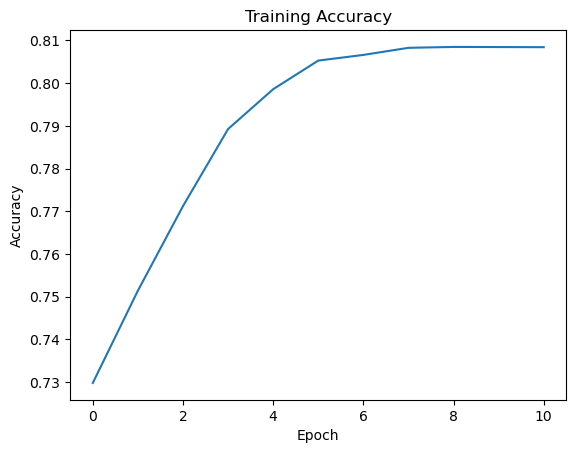

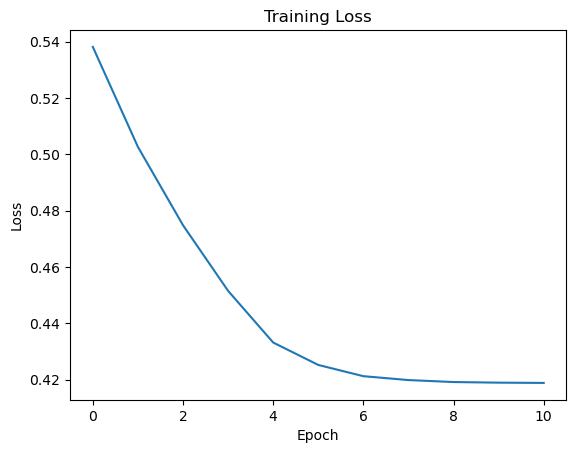

In [41]:
#visualization and scores
# training accuracy
#did not converage 
    #few reasons why i think it happened
    # - data augmentation is not included here
    # - hyperparamters must be adjusted; Epochs, neurons, learning rate, batch size, 
plt.plot(training_results.history['binary_accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# training loss
plt.plot(training_results.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [42]:
test_generator.reset()
df_test['pred'] = model.predict(test_generator).ravel()
df_test

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step

2024-04-19 16:46:16.345160: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step


,study_type,patient_id,img_path,label,pred
0,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0,0.223235
1,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0,0.269770
2,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0,0.418551
3,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0,0.506813
4,XR_FOREARM,patient11408,MURA-v1.1/valid/XR_FOREARM/patient11408/study1...,1,0.095442
...,...,...,...,...,...
3192,XR_ELBOW,patient11536,MURA-v1.1/valid/XR_ELBOW/patient11536/study1_n...,0,0.066599
3193,XR_ELBOW,patient11402,MURA-v1.1/valid/XR_ELBOW/patient11402/study1_n...,0,0.058920
3194,XR_ELBOW,patient11402,MURA-v1.1/valid/XR_ELBOW/patient11402/study1_n...,0,0.114611
3195,XR_ELBOW,patient11875,MURA-v1.1/valid/XR_ELBOW/patient11875/study1_n...,0,0.321399


In [43]:
df_test['pred'] = np.where(df_test.pred>0.5, 1, 0)
df_test

,study_type,patient_id,img_path,label,pred
0,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0,0
1,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0,0
2,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0,0
3,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0,1
4,XR_FOREARM,patient11408,MURA-v1.1/valid/XR_FOREARM/patient11408/study1...,1,0
...,...,...,...,...,...
3192,XR_ELBOW,patient11536,MURA-v1.1/valid/XR_ELBOW/patient11536/study1_n...,0,0
3193,XR_ELBOW,patient11402,MURA-v1.1/valid/XR_ELBOW/patient11402/study1_n...,0,0
3194,XR_ELBOW,patient11402,MURA-v1.1/valid/XR_ELBOW/patient11402/study1_n...,0,0
3195,XR_ELBOW,patient11875,MURA-v1.1/valid/XR_ELBOW/patient11875/study1_n...,0,0


In [44]:
df_test.to_csv('test_w_preds_vgg.csv')

In [ ]:
#TODO test the model
#need to talk to team about questions on how the validation dataset will be split 